In [1]:
import torch
import numpy as np
import torch.nn as nn

In [2]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/T3"

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
import urllib.request
from urllib.error import HTTPError
import os
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"

pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f'downloading..{file_url}')
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("something went wrong..{e}")

In [4]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__() 
        self.name = self.__class__.__name__
        self.config = {"name":self.name}

In [5]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1/(1+torch.exp(-x))

In [6]:
sig = Sigmoid()
sig.config, sig.name, sig.forward(torch.tensor(2))

({'name': 'Sigmoid'}, 'Sigmoid', tensor(0.8808))

In [7]:
class Tanh(ActivationFunction):
    def forward(self, x):
        exp, neg_exp = torch.exp(x), torch.exp(-x)
        return (exp-neg_exp)/(exp+neg_exp) 

In [8]:
class Relu(ActivationFunction):
    def forward(self, x):
        return x * (x>0).float()
relu = Relu()
relu.forward(torch.Tensor([20,1,-8]))

tensor([20.,  1., -0.])

In [9]:
class LeakyRelu(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config['alpha'] = alpha
    def forward(self, x):
        return torch.where(x > 0, x , x*self.config['alpha'])
    
lr = LeakyRelu()
lr.forward(torch.Tensor([20,1,-8]))

tensor([20.0000,  1.0000, -0.8000])

In [10]:
t = torch.Tensor([20,1,-8])

In [11]:
class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x>0, x, torch.exp(x)-1)
elu = ELU()
elu.forward(t), elu(t)


(tensor([20.0000,  1.0000, -0.9997]), tensor([20.0000,  1.0000, -0.9997]))

In [12]:
class Swish(ActivationFunction):
    def forward(self, x):
        return x*torch.sigmoid(x)

In [13]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": Relu,   
    "leakyrelu": LeakyRelu,
    "elu": ELU,
    "swish": Swish
}

In [14]:
def get_grads(act_fn, x):
    x = x.clone().requires_grad_()
    out = act_fn(x)
    out.sum().backward()
    # print(x.grad)
    return x.grad

In [15]:
get_grads(Swish(), t)

tensor([ 1.0000,  0.9277, -0.0023])

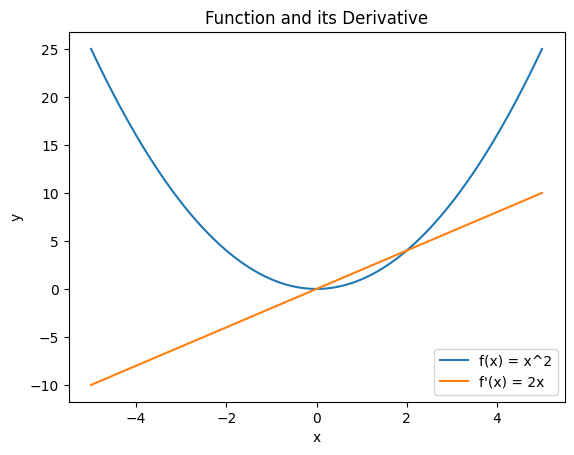

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function and its derivative
def f(x):
    return x ** 2

def f_prime(x):
    return 2 * x

# Generate x values
x = np.linspace(-5, 5, 100)

# Calculate y values for the function and its derivative
y = f(x)
y_prime = f_prime(x)

# Create a figure and an axes object
fig, ax = plt.subplots()

# Plot the function and its derivative using the axes object
ax.plot(x, y, label="f(x) = x^2")
ax.plot(x, y_prime, label="f'(x) = 2x")

# Add a legend and titles
ax.legend()
ax.set_title("Function and its Derivative")
ax.set_xlabel("x")
ax.set_ylabel("y")

# Display the plot
plt.show()


In [17]:
t = torch.linspace(-5,5,1000)

In [18]:
def vis_act_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ax.plot(x,y, label="act_fn")
    ax.plot(x,y_grads, label="grad")
    ax.legend()
    ax.set_title(act_fn.name)
    ax.set_ylim(-1.5, x.max())

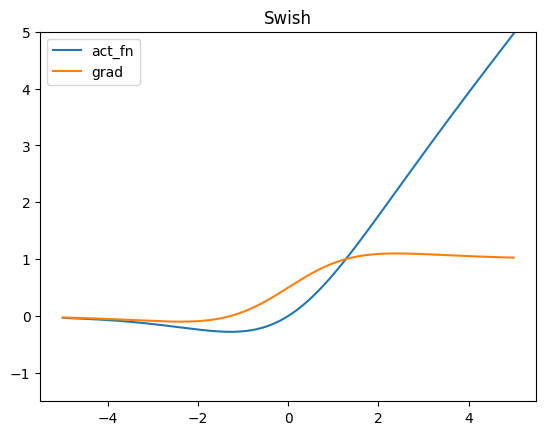

In [19]:
fig, ax = plt.subplots()
vis_act_fn(Swish(), ax, t)

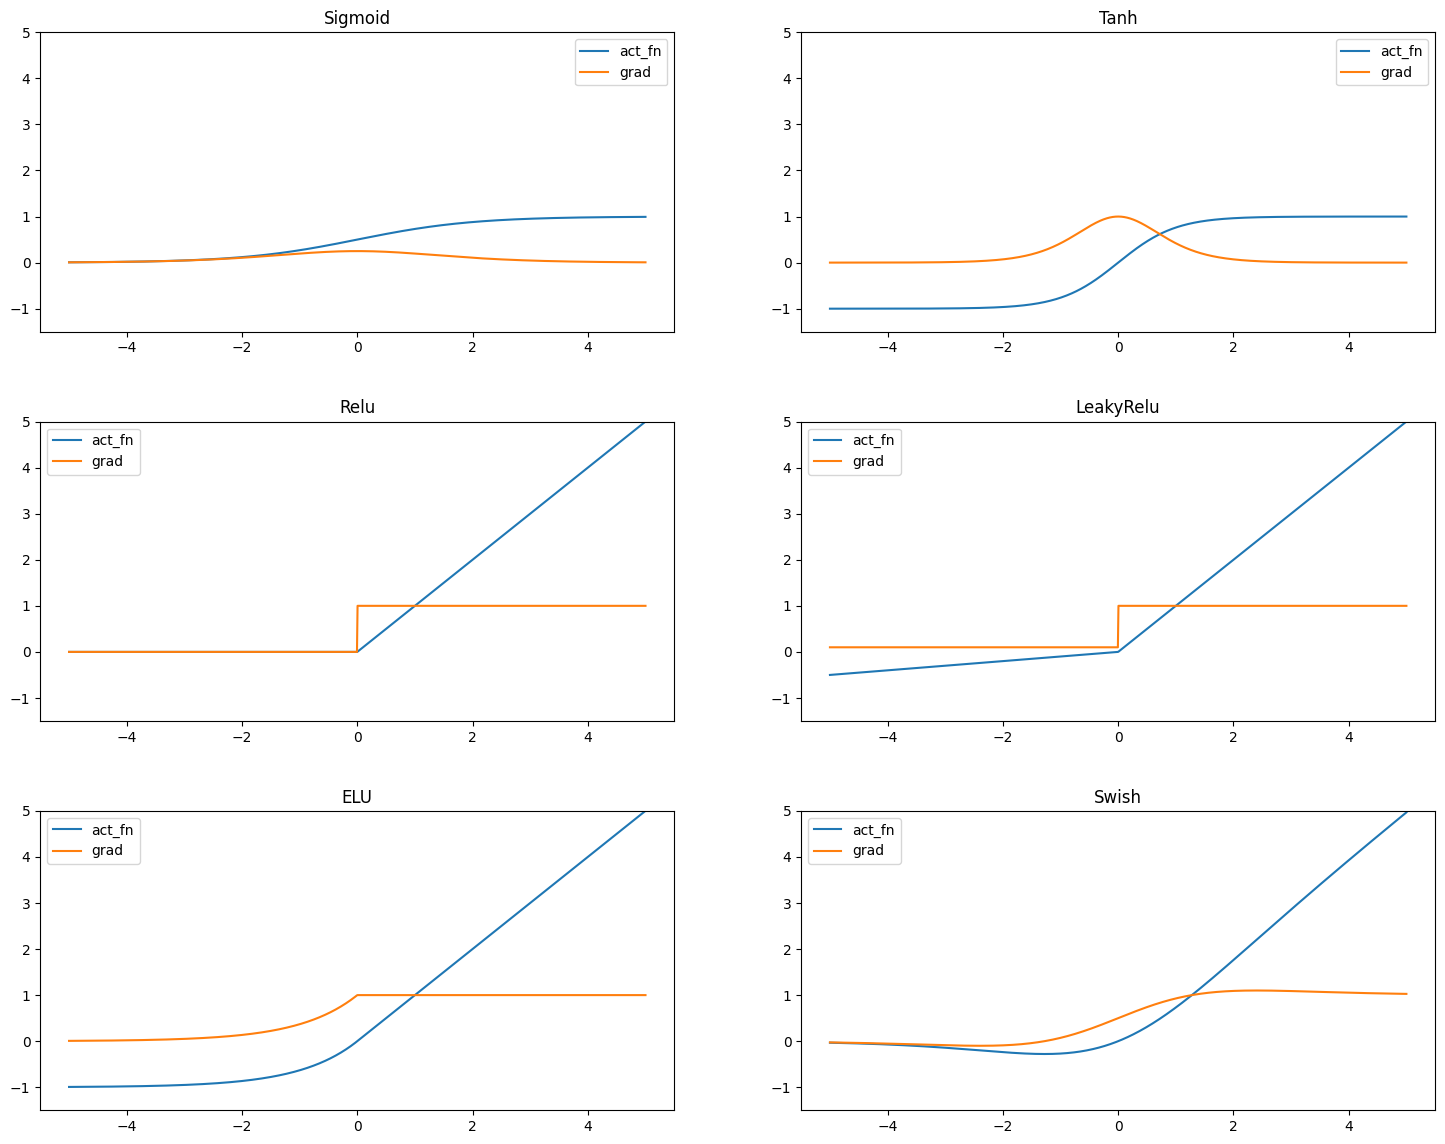

In [20]:
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
# act_fns 
fig, ax = plt.subplots(3, 2, figsize=(18, 14))
ax
for idx, act_fn in enumerate(act_fns):
    ax_idx = divmod(idx,2)
    vis_act_fn(act_fn, ax[ax_idx], t) 
fig.subplots_adjust(hspace=0.3)
plt.show()

Model creation


In [21]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        layers = []
        layers_size = [input_size] + hidden_sizes
        for layer_idx in range(1, len(layers_size)):
            layers += [nn.Linear(layers_size[layer_idx-1], layers_size[layer_idx]), act_fn]
        layers += [nn.Linear(layers_size[-1], num_classes)] 
        self.layers = nn.Sequential(*layers)
        self.config = {'act_fn':act_fn.config, 'input_size':input_size, 'num_classes':num_classes, 'hidden_sizes':hidden_sizes}
        print(self.config)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        # x = torch.einsum('ijk->i', x)
        # print(x)
        out = self.layers(x)
        return out

In [22]:
bn = BaseNetwork(LeakyRelu(), 768, 10, [256, 512, 768, 256])
bn.layers

{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 768, 'num_classes': 10, 'hidden_sizes': [256, 512, 768, 256]}


Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): LeakyRelu()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): LeakyRelu()
  (4): Linear(in_features=512, out_features=768, bias=True)
  (5): LeakyRelu()
  (6): Linear(in_features=768, out_features=256, bias=True)
  (7): LeakyRelu()
  (8): Linear(in_features=256, out_features=10, bias=True)
)

In [23]:
x = torch.randint(1,5, (768,5,6), dtype=torch.float32)
x.dtype
# x
# y = x.view(x.size(0), -1)
# x.shape,y.shape

torch.float32

In [24]:
# bn(x)

In [25]:
import torch.utils.data as data
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,), (.5,))])
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_dataloader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
test_dataloader = data.DataLoader(test_set, batch_size=1024, shuffle=True, drop_last=False)
val_dataloader = data.DataLoader(val_set, batch_size=1024, shuffle=True, drop_last=False)


In [26]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(49, 10, 10)

In [27]:
train_set[0][1]

0

In [28]:
exp_img = [train_set[i][0] for i in range(16)]
torch.stack(exp_img, dim=0).shape

torch.Size([16, 1, 28, 28])

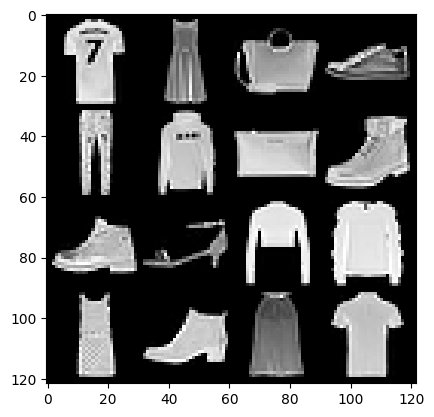

In [29]:
img_grid = torchvision.utils.make_grid(torch.stack(exp_img, dim=0), nrow=4, normalize=True).permute(1,2,0)
plt.imshow(img_grid)

In [30]:
import json
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name+".config")
def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name+".tar")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    # print(config_file, model_file)
    assert os.path.isfile(config_file), f"The file does not exist"
    assert os.path.isfile(model_file), f"The file does not exist"
    with open(config_file, "r") as file:
        config_dict = json.load(file)
        print(config_dict)
    if net is None:
        # def __init__(self, act_fn, input_size, num_classes, hidden_sizes):
        act_fn = config_dict.pop('act_fn').pop('name').lower()
        print(act_fn, act_fn_by_name[act_fn], config_dict)
        net = BaseNetwork(act_fn_by_name[act_fn](), **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, 'w') as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)    

In [31]:
MODEL_PATH = "../saved_models/T3"
MODEL_NAME = "FashionMNIST_relu"
device

device(type='cuda')

In [32]:
load_model(MODEL_PATH, MODEL_NAME).to(device)

{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
relu <class '__main__.Relu'> {'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


BaseNetwork(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Relu()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Relu()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Relu()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Relu()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): Relu()
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [33]:
import torch.nn.functional as F
from icecream import ic 
import seaborn as sns
def visualize_gradients(net, color="C0"):
    net.eval()
    small_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    print(imgs.shape, labels.shape)
    net.to(device)
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    # import ipdb;  ipdb.set_trace()
    loss.backward() 
    # print(net.named_parameters())
    # for names, params in net.named_parameters():
    #     print(names, params.shape)
    #     print(params.grad.data.view(-1).cpu().clone().numpy())
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    # grads1 = {name: params for name, params in net.named_parameters() if "weight" in name}
    # print(grads)
    # print(grads1)
    net.zero_grad()

    columns = len(grads)
    ic(columns)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        ic(key)
        key_ax = ax[fig_index%columns]
        ic(key, key_ax)
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
        

{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >
ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >


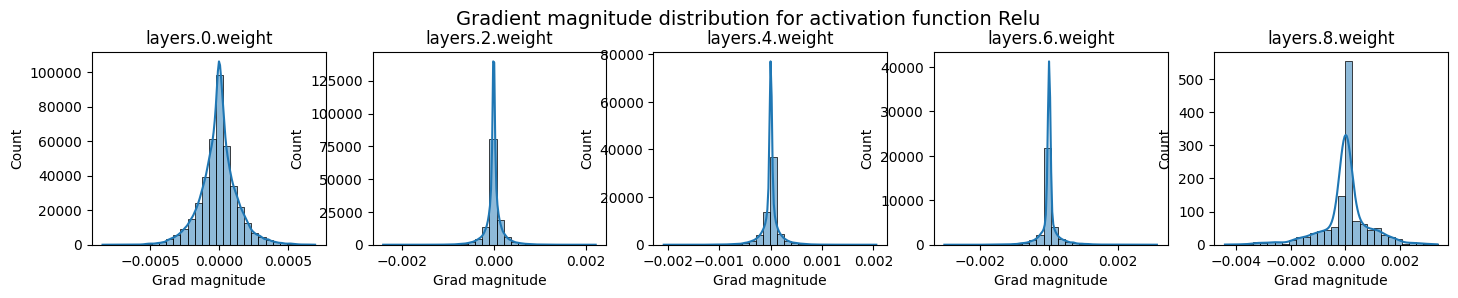

In [34]:
net = BaseNetwork(Relu())
visualize_gradients(net)        

ic| act_name: 'sigmoid', act_fn: <class '__main__.Sigmoid'>
ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


{'act_fn': {'name': 'Sigmoid'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >
ic| act_name: 'tanh', act_fn: <class '__main__.Tanh'>
ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


{'act_fn': {'name': 'Tanh'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >
ic| act_name: 'relu', act_fn: <class '__main__.Relu'>


{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >
ic| act_name: 'leakyrelu', act_fn: <class '__main__.LeakyRelu'>
ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >
ic| act_name: 'elu', act_fn: <class '__main__.ELU'>
ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


{'act_fn': {'name': 'ELU'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >
ic| act_name: 'swish', act_fn: <class '__main__.Swish'>
ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


{'act_fn': {'name': 'Swish'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >


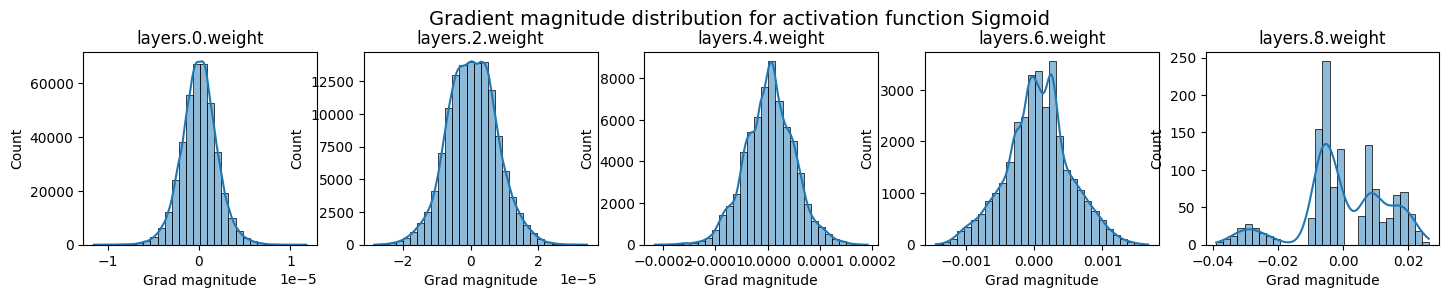

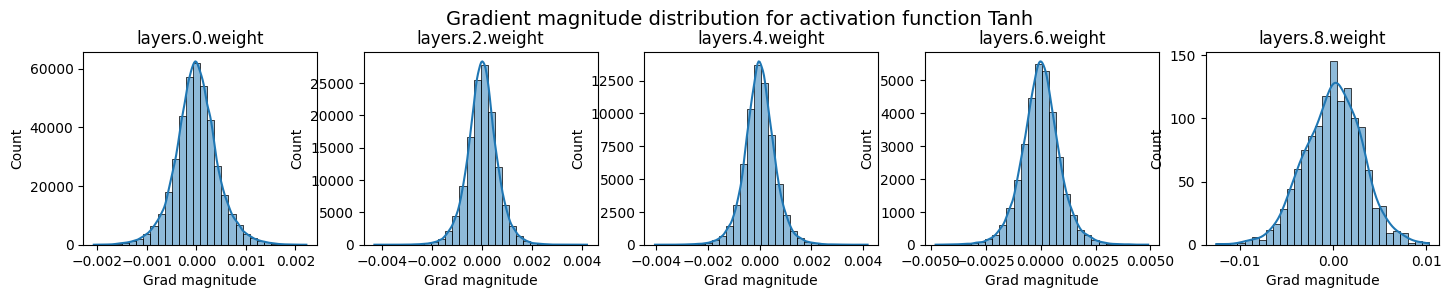

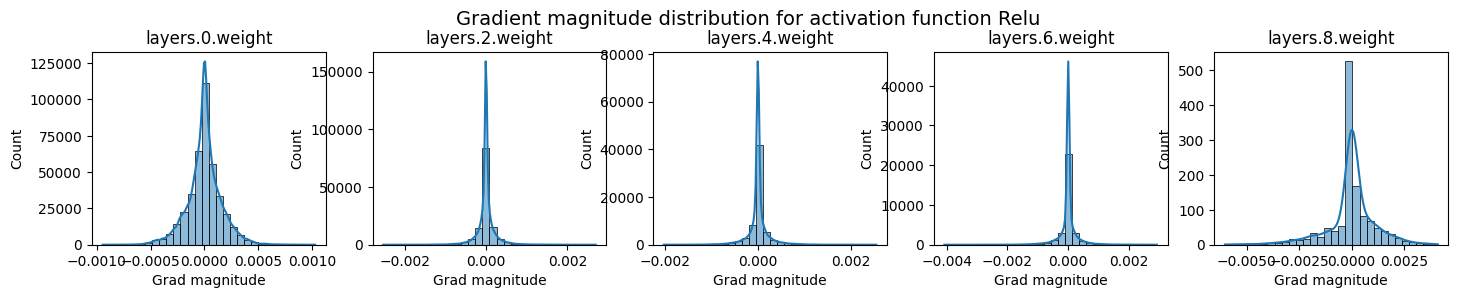

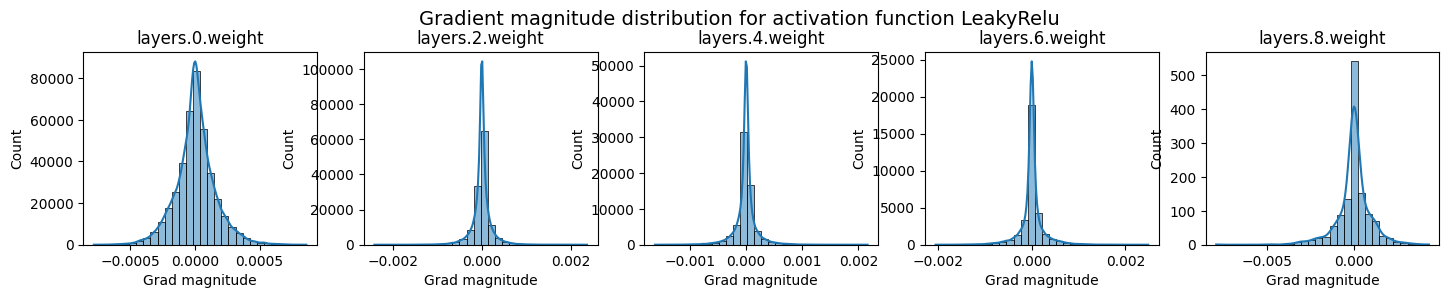

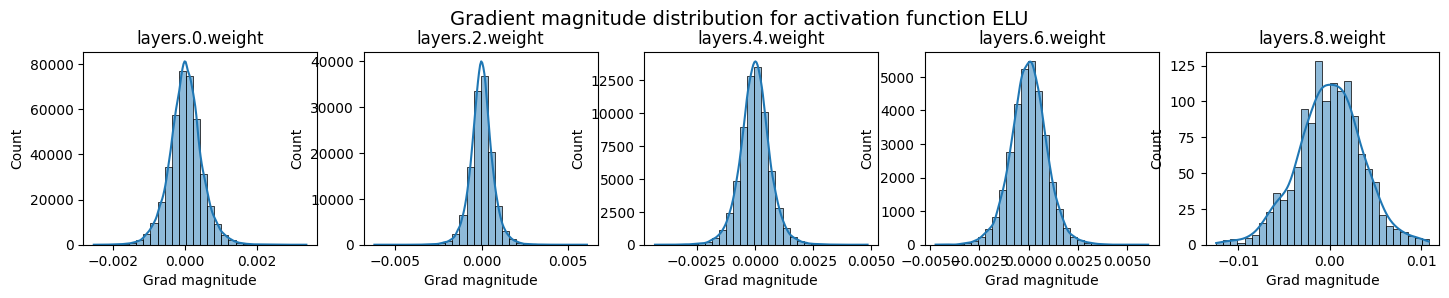

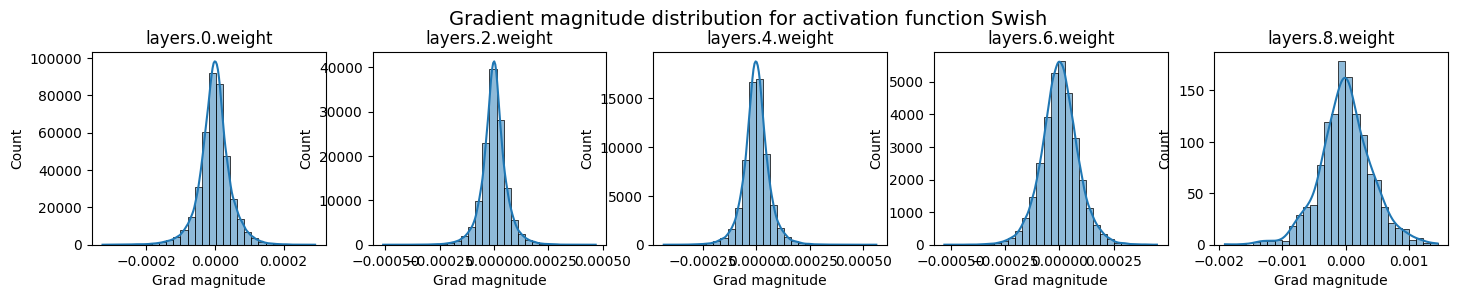

In [35]:
for act_name, act_fn in act_fn_by_name.items():
    ic(act_name, act_fn)
    net = BaseNetwork(act_fn())
    visualize_gradients(net)

In [36]:

MODEL_PATH = "../saved_models/T3"
MODEL_NAME = "FashionMNIST_relu"
CHECKPOINT_PATH


'../saved_models/T3'

In [37]:
# null pointer to stop the execution 
a = 1/0

ZeroDivisionError: division by zero

TRAINING

In [ ]:
from tqdm import tqdm
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name=model_name))
    ic(file_exists)
    if file_exists and not overwrite:
        print(f'{model_name}.tar exists, skipping the training.....')
    else:
        if file_exists:
                print(f'{model_name}.tar exists, will be overwritten.')
        print(f'{model_name} is setting up for training.....')
        # defining optimizer, loss, and data loader
        optim = torch.optim.SGD(net.parameters(), lr = 1e-2, momentum=0.9)
        loss_module = nn.CrossEntropyLoss()
        # tbc
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        best_val_epoch = -1
        val_scores = []
        for epoch in range(max_epochs):
            net.train()
            true_preds, count = 0, 0
            for image, labels in tqdm(train_loader_local, desc=f'epoch: {epoch+1}', leave=False):
                # ic(".....")
                image, labels = image.to(device), labels.to(device)
                optim.zero_grad()
                preds = net(image)
                loss = loss_module(preds, labels)
                loss.backward()
                optim.step()
                # ic(preds.shape)
                # ic(labels.shape)
                # ic(preds.argmax(dim=-1).shape)
                true_preds += (preds.argmax(dim=-1)==labels).sum()
                count += labels.shape[0]
            train_acc = true_preds/count
            ic(train_acc)

            # validation
            val_acc = test_model(net, val_dataloader)
            val_scores.append(val_acc)
            if len(val_scores)==1 or val_acc > val_scores[best_val_epoch]:
                print((f"new best performance with val_acc: {val_acc*100.0:4.2f}% ").center(50, "=")+"\n")
                print("saving checkpoint.............")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch=epoch
            elif (best_val_epoch <= epoch-patience):
                print(f'Early stopping dure to no improvements over {patience} epochs....best_epoch: {best_val_epoch}, current epoch: {epoch}')
                break
                # Plot a curve of the validation accuracy
            
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_dataloader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc
                

In [ ]:
def test_model(net, data_loader):
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in tqdm(data_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs)
            true_preds+= (preds.argmax(dim=-1)==labels).sum()
            count += labels.shape[0]
    test_acc = true_preds/count
    return test_acc.cpu()



ic| file_exists: True


Training BaseNetwork with sigmoid activation...
{'act_fn': {'name': 'Sigmoid'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
FashionMNIST_sigmoid.tar exists, will be overwritten.
FashionMNIST_sigmoid is setting up for training.....


epoch: 1:   1%|          | 2/195 [00:00<00:10, 19.00it/s]

ic                                                         | train_acc: tensor(0.0990, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


====new best performance with val_acc: 9.47% =====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.1004, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 10.18% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.1016, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


====new best performance with val_acc: 10.64% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.1006, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.96it/s]
ic                                                         | train_acc: tensor(0.1000, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.96it/s]
ic                                                         | train_acc: tensor(0.0983, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.96it/s]
ic                                                         | train_acc: tensor(0.0994, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.94it/s]
ic                                                         | train_acc: tensor(0.0989, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


====new best performance with val_acc: 11.64% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.1018, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]
ic                                                          | train_acc: tensor(0.1033, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.1018, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.1021, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.0992, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
ic                                                          | train_acc: tensor(0.0993, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.1

Early stopping dure to no improvements over 7 epochs....best_epoch: 7, current epoch: 14


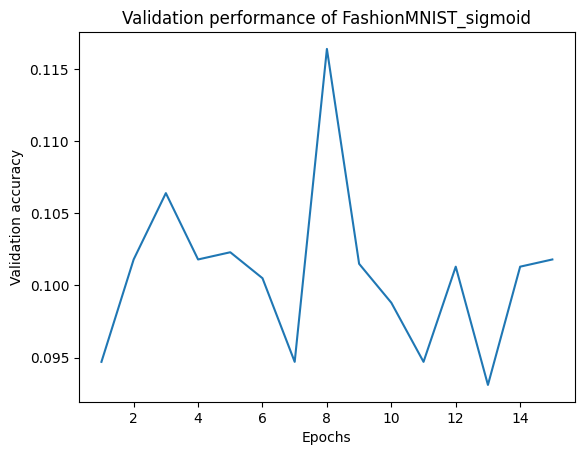

{'act_fn': {'name': 'Sigmoid'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
ic| file_exists: True


============= Test accuracy: 11.68% ==============

Training BaseNetwork with tanh activation...
{'act_fn': {'name': 'Tanh'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
FashionMNIST_tanh.tar exists, will be overwritten.
FashionMNIST_tanh is setting up for training.....


ic                                                         | train_acc: tensor(0.5975, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 76.77% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8036, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


====new best performance with val_acc: 82.42% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8328, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 84.19% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8472, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


====new best performance with val_acc: 85.47% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8561, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


====new best performance with val_acc: 85.64% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8605, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


====new best performance with val_acc: 85.90% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8668, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


====new best performance with val_acc: 86.32% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8720, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


====new best performance with val_acc: 86.65% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8765, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


====new best performance with val_acc: 87.22% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8788, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.8836, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


====new best performance with val_acc: 87.50% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8849, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 87.86% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8882, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


====new best performance with val_acc: 88.19% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8900, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.8940, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.8953, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.8954, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


====new best performance with val_acc: 88.26% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8989, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]
ic                                                          | train_acc: tensor(0.9042, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


====new best performance with val_acc: 88.64% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9037, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.9033, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.9081, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                          | train_acc: tensor(0.9090, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


====new best performance with val_acc: 88.81% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9107, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]
ic                                                          | train_acc: tensor(0.9129, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 89.04% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9132, device='cuda:0')
100%|██████████| 10/10 [00:02<00:00,  4.85it/s]
ic                                                          | train_acc: tensor(0.9157, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.9179, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]
ic                                                          | train_acc: tensor(0.9191, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.9181, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


====new best performance with val_acc: 89.32% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9225, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.94it/s]
ic                                                          | train_acc: tensor(0.9253, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


====new best performance with val_acc: 89.42% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9256, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.96it/s]
ic                                                          | train_acc: tensor(0.9253, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  6.01it/s]
ic                                                          | train_acc: tensor(0.9286, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.96it/s]
ic                                                          | train_acc: tensor(0.9275, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.9320, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.9274, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]
ic                                                          | train_acc: tensor(0.

====new best performance with val_acc: 89.61% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9363, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.9360, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.9375, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9402, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.9416, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]
ic                                                          | train_acc: tensor(0.9421, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
ic                                                          | train_acc: tensor(0.

Early stopping dure to no improvements over 7 epochs....best_epoch: 38, current epoch: 45


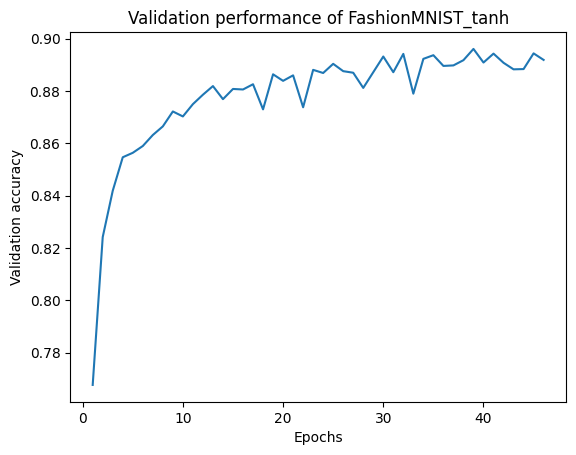

{'act_fn': {'name': 'Tanh'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic| file_exists: True


============= Test accuracy: 88.86% ==============

Training BaseNetwork with relu activation...
{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
FashionMNIST_relu.tar exists, will be overwritten.
FashionMNIST_relu is setting up for training.....


ic                                                         | train_acc: tensor(0.3310, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


====new best performance with val_acc: 62.83% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.7233, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


====new best performance with val_acc: 79.34% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8117, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


====new best performance with val_acc: 82.49% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8409, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


====new best performance with val_acc: 85.37% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8562, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


====new best performance with val_acc: 86.44% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8658, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 86.62% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8741, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


====new best performance with val_acc: 87.29% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8802, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 87.74% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8846, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 87.99% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8912, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


====new best performance with val_acc: 88.47% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8941, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
ic                                                          | train_acc: tensor(0.8969, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9026, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]
ic                                                          | train_acc: tensor(0.9041, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


====new best performance with val_acc: 89.29% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9072, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                          | train_acc: tensor(0.9120, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.9136, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.9172, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


====new best performance with val_acc: 89.34% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9220, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.9209, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.9246, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


====new best performance with val_acc: 89.36% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9300, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.95it/s]
ic                                                          | train_acc: tensor(0.9297, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.98it/s]
ic                                                          | train_acc: tensor(0.9331, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


====new best performance with val_acc: 89.56% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9359, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.9339, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9403, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]
ic                                                          | train_acc: tensor(0.9432, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.9455, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


====new best performance with val_acc: 89.63% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9446, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.97it/s]
ic                                                          | train_acc: tensor(0.9468, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
ic                                                          | train_acc: tensor(0.9494, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


====new best performance with val_acc: 89.77% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9510, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.47it/s]
ic                                                          | train_acc: tensor(0.9508, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.9530, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                          | train_acc: tensor(0.9545, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.9602, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.9546, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.

====new best performance with val_acc: 89.93% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9601, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.9618, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.9636, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.9683, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.9670, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.9678, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.

Early stopping dure to no improvements over 7 epochs....best_epoch: 38, current epoch: 45


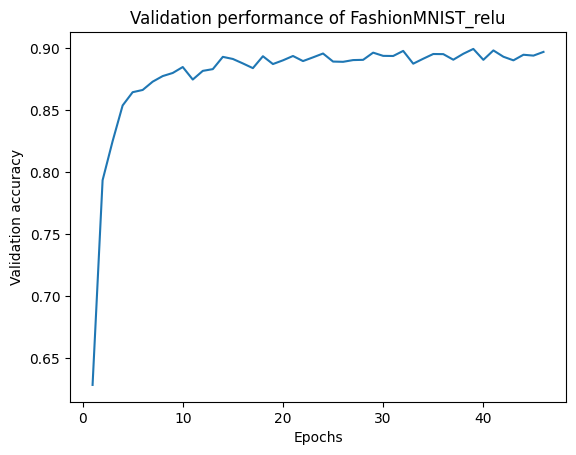

{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]
ic| file_exists: True


============= Test accuracy: 88.87% ==============

Training BaseNetwork with leakyrelu activation...
{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
FashionMNIST_leakyrelu.tar exists, will be overwritten.
FashionMNIST_leakyrelu is setting up for training.....


ic                                                         | train_acc: tensor(0.3483, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


====new best performance with val_acc: 65.39% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.7338, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


====new best performance with val_acc: 78.78% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8142, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


====new best performance with val_acc: 82.71% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8384, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


====new best performance with val_acc: 84.75% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8537, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


====new best performance with val_acc: 86.14% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8620, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 86.25% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8720, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 87.11% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8777, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 87.46% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8821, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 87.93% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8876, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


====new best performance with val_acc: 88.35% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8890, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.8920, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.8973, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 88.43% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8998, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


====new best performance with val_acc: 88.99% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9019, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9065, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9067, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]
ic                                                          | train_acc: tensor(0.9116, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 89.21% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9158, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
ic                                                          | train_acc: tensor(0.9145, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.94it/s]
ic                                                          | train_acc: tensor(0.9166, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


====new best performance with val_acc: 89.45% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9247, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]
ic                                                          | train_acc: tensor(0.9228, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.95it/s]
ic                                                          | train_acc: tensor(0.9276, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
ic                                                          | train_acc: tensor(0.9289, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]
ic                                                          | train_acc: tensor(0.9279, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.95it/s]
ic                                                          | train_acc: tensor(0.9341, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
ic                                                          | train_acc: tensor(0.

Early stopping dure to no improvements over 7 epochs....best_epoch: 20, current epoch: 27


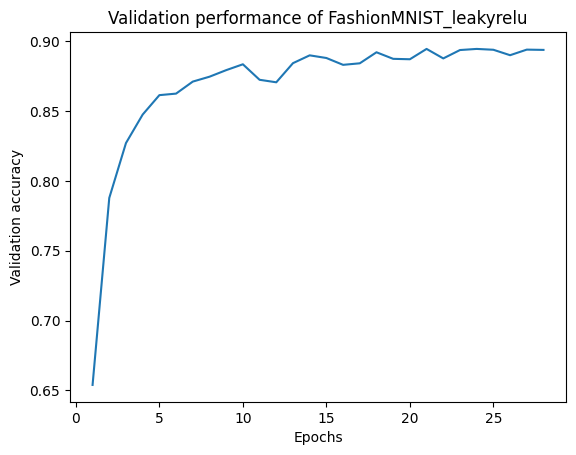

{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic| file_exists: True


============= Test accuracy: 88.13% ==============

Training BaseNetwork with elu activation...
{'act_fn': {'name': 'ELU'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
FashionMNIST_elu.tar exists, will be overwritten.
FashionMNIST_elu is setting up for training.....


ic                                                         | train_acc: tensor(0.5968, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


====new best performance with val_acc: 77.31% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8012, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


====new best performance with val_acc: 82.81% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8287, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


====new best performance with val_acc: 84.21% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8429, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 85.51% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8513, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                         | train_acc: tensor(0.8570, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


====new best performance with val_acc: 86.01% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8628, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


====new best performance with val_acc: 86.15% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8674, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


====new best performance with val_acc: 86.40% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8714, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


====new best performance with val_acc: 87.01% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8754, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.8762, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 87.03% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8788, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


====new best performance with val_acc: 87.61% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8846, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 87.76% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8846, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                          | train_acc: tensor(0.8850, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


====new best performance with val_acc: 88.26% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8905, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                          | train_acc: tensor(0.8889, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]
ic                                                          | train_acc: tensor(0.8910, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]
ic                                                          | train_acc: tensor(0.8948, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]
ic                                                          | train_acc: tensor(0.8980, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]
ic                                                          | train_acc: tensor(0.8978, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


====new best performance with val_acc: 88.61% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9008, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9013, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9042, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.9043, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.9060, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9064, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.

====new best performance with val_acc: 88.72% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9110, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.9109, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
ic                                                          | train_acc: tensor(0.9125, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.43it/s]
ic                                                          | train_acc: tensor(0.9164, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 88.88% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9152, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
ic                                                          | train_acc: tensor(0.9163, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.9177, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
ic                                                          | train_acc: tensor(0.9162, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.9203, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
ic                                                          | train_acc: tensor(0.9196, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.

====new best performance with val_acc: 88.97% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9246, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9236, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


====new best performance with val_acc: 89.08% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9267, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


====new best performance with val_acc: 89.36% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9289, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]
ic                                                          | train_acc: tensor(0.9308, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9280, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.9291, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


====new best performance with val_acc: 89.45% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9321, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.9313, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                          | train_acc: tensor(0.9349, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


====new best performance with val_acc: 89.60% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9346, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


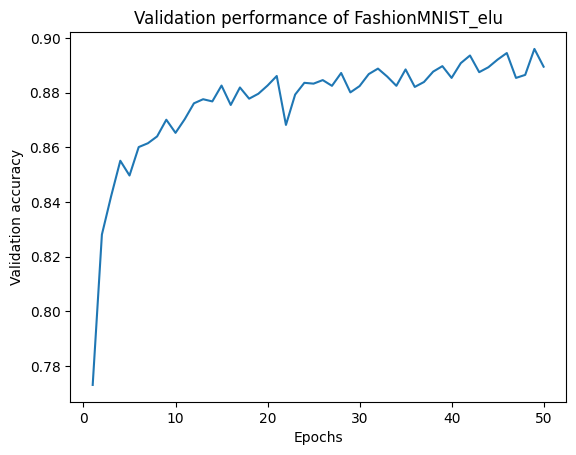

{'act_fn': {'name': 'ELU'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic| file_exists: True


============= Test accuracy: 88.60% ==============

Training BaseNetwork with swish activation...
{'act_fn': {'name': 'Swish'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
FashionMNIST_swish.tar exists, will be overwritten.
FashionMNIST_swish is setting up for training.....


ic                                                         | train_acc: tensor(0.1361, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


====new best performance with val_acc: 31.55% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.2802, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                         | train_acc: tensor(0.4699, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


====new best performance with val_acc: 67.82% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.7352, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


====new best performance with val_acc: 78.00% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.7949, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 82.07% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8211, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


====new best performance with val_acc: 83.46% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8360, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


====new best performance with val_acc: 84.01% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8448, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.94it/s]
ic                                                         | train_acc: tensor(0.8492, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 85.13% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8581, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


====new best performance with val_acc: 85.64% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8597, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.8640, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


====new best performance with val_acc: 85.87% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8684, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 86.78% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8716, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.8723, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
ic                                                          | train_acc: tensor(0.8782, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


====new best performance with val_acc: 87.24% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8777, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


====new best performance with val_acc: 87.48% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8797, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


====new best performance with val_acc: 87.68% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8843, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.8873, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 87.81% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8884, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


====new best performance with val_acc: 88.07% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8920, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]
ic                                                          | train_acc: tensor(0.8920, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
ic                                                          | train_acc: tensor(0.8963, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.8973, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.94it/s]
ic                                                          | train_acc: tensor(0.8959, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


====new best performance with val_acc: 88.54% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8998, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.9011, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.39it/s]
ic                                                          | train_acc: tensor(0.9028, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.92it/s]
ic                                                          | train_acc: tensor(0.9038, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]
ic                                                          | train_acc: tensor(0.9050, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.9072, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


====new best performance with val_acc: 88.70% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9104, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.9099, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.93it/s]
ic                                                          | train_acc: tensor(0.9135, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.9114, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


====new best performance with val_acc: 88.75% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9156, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9135, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.94it/s]
ic                                                          | train_acc: tensor(0.9173, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.9188, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


====new best performance with val_acc: 88.94% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9205, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9220, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.9235, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                          | train_acc: tensor(0.9258, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.95it/s]
ic                                                          | train_acc: tensor(0.9236, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 88.99% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9280, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


====new best performance with val_acc: 89.17% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9285, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]
ic                                                          | train_acc: tensor(0.9304, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.9320, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.9314, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


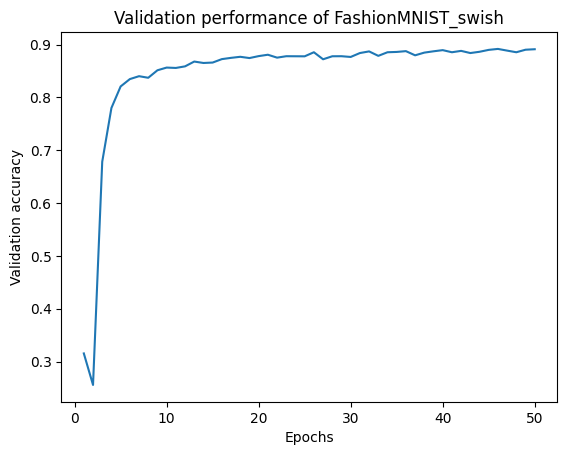

{'act_fn': {'name': 'Swish'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]

============= Test accuracy: 88.39% ==============



In [ ]:
for act_name, act_fn in act_fn_by_name.items():
    print(f"Training BaseNetwork with {act_name} activation...")
    set_seed(42)
    # net = BaseNetwork(act_fn()).to(device)
    # creating network with more hidden layers 
    # input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
    # adding one more hdden layer of 256 
    hidden_sizes=[512, 256, 256, 256 , 128]
    net = BaseNetwork(act_fn(), hidden_sizes=hidden_sizes).to(device)
    train_model(net, f'FashionMNIST_{act_name}', overwrite=True)
    # test_model(net, val_dataloader)
    # break


In [ ]:
import math
def visualize_activations(net, color='C0'):
    activations = {}
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    img, label = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # label = label.to(device)
        for layer_idx, layer in enumerate(net.layers[:-1]):
            img = layer(img)
            activations[layer_idx] = img.view(-1).cpu().numpy()
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

ic| i: 0
ic| act_fn_name: 'sigmoid'


{'act_fn': {'name': 'Sigmoid'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
sigmoid <class '__main__.Sigmoid'> {'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
{'act_fn': {'name': 'Sigmoid'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


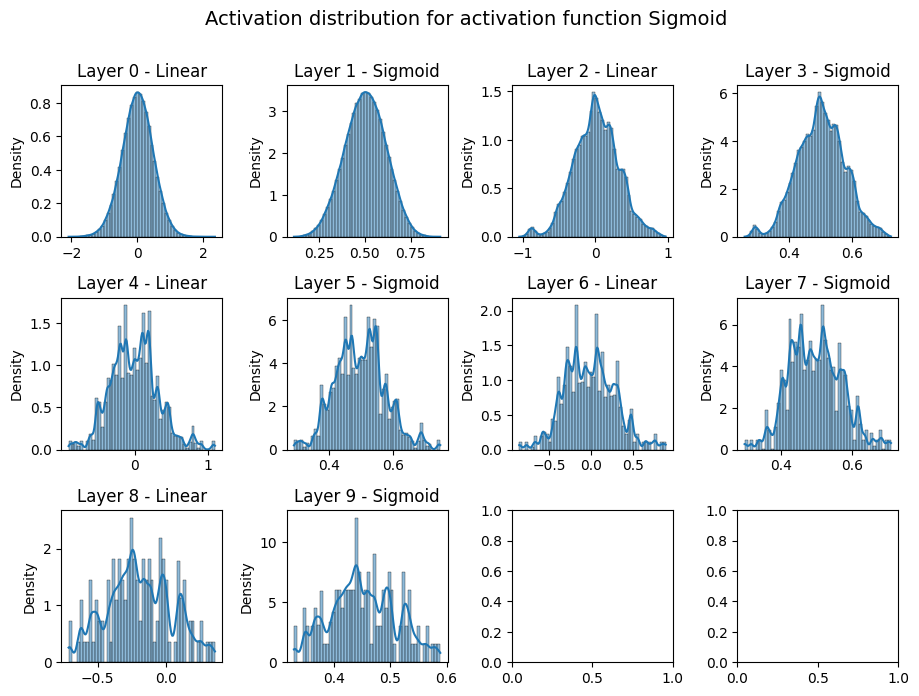

ic| i: 1
ic| act_fn_name: 'tanh'


{'act_fn': {'name': 'Tanh'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
tanh <class '__main__.Tanh'> {'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
{'act_fn': {'name': 'Tanh'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


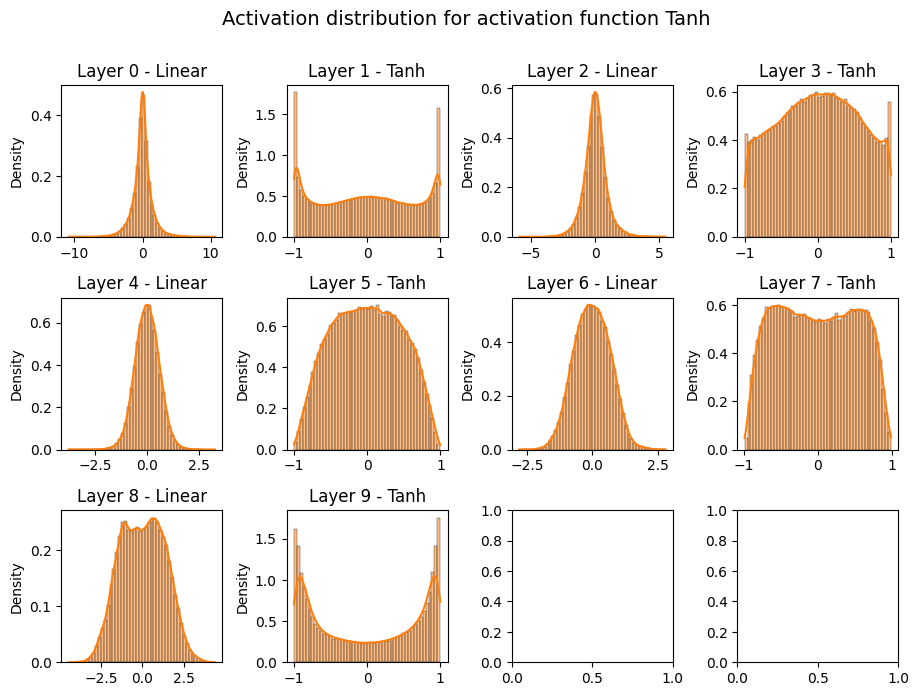

ic| i: 2
ic| act_fn_name: 'relu'


{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
relu <class '__main__.Relu'> {'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


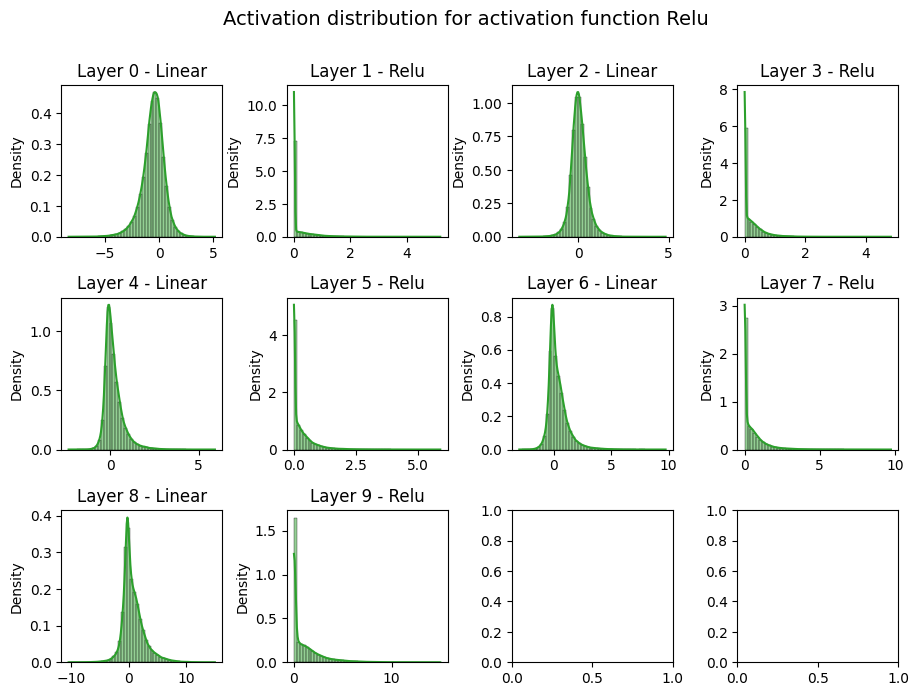

ic| i: 3
ic| act_fn_name: 'leakyrelu'


{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
leakyrelu <class '__main__.LeakyRelu'> {'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


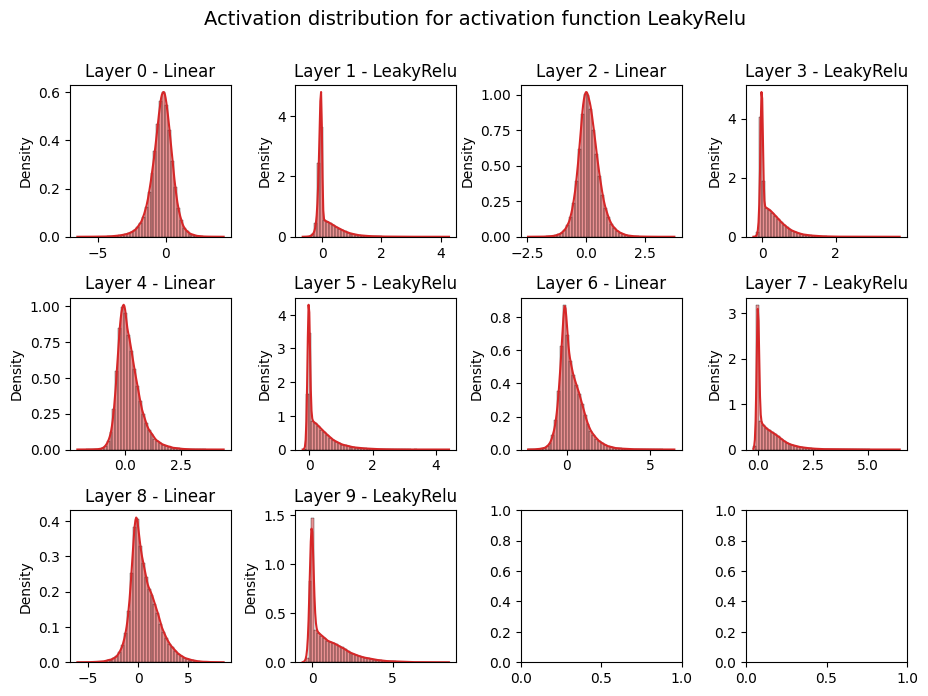

ic| i: 4
ic| act_fn_name: 'elu'


{'act_fn': {'name': 'ELU'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
elu <class '__main__.ELU'> {'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
{'act_fn': {'name': 'ELU'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


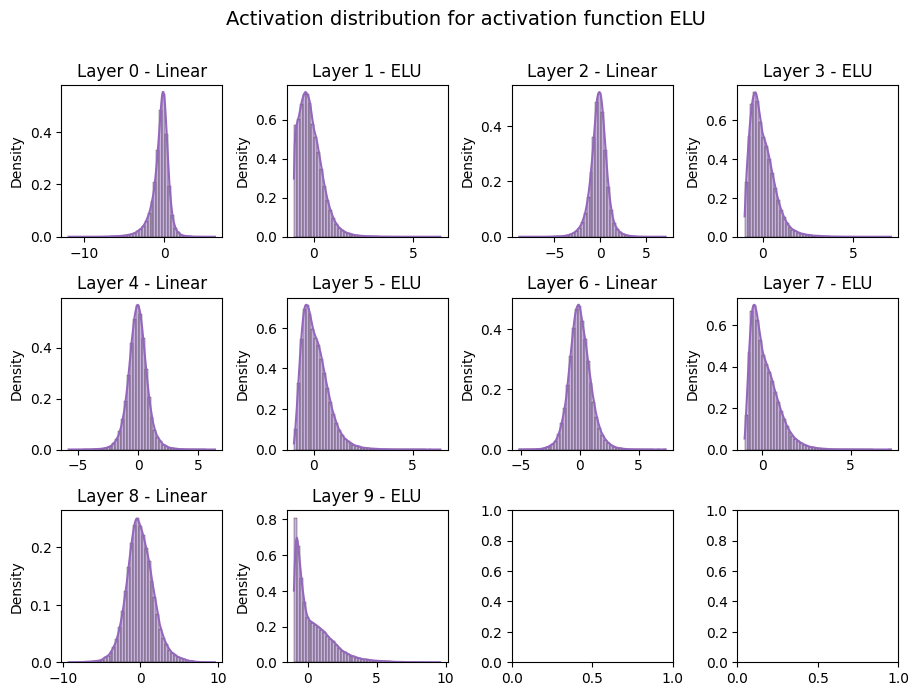

ic| i: 5
ic| act_fn_name: 'swish'


{'act_fn': {'name': 'Swish'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
swish <class '__main__.Swish'> {'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
{'act_fn': {'name': 'Swish'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


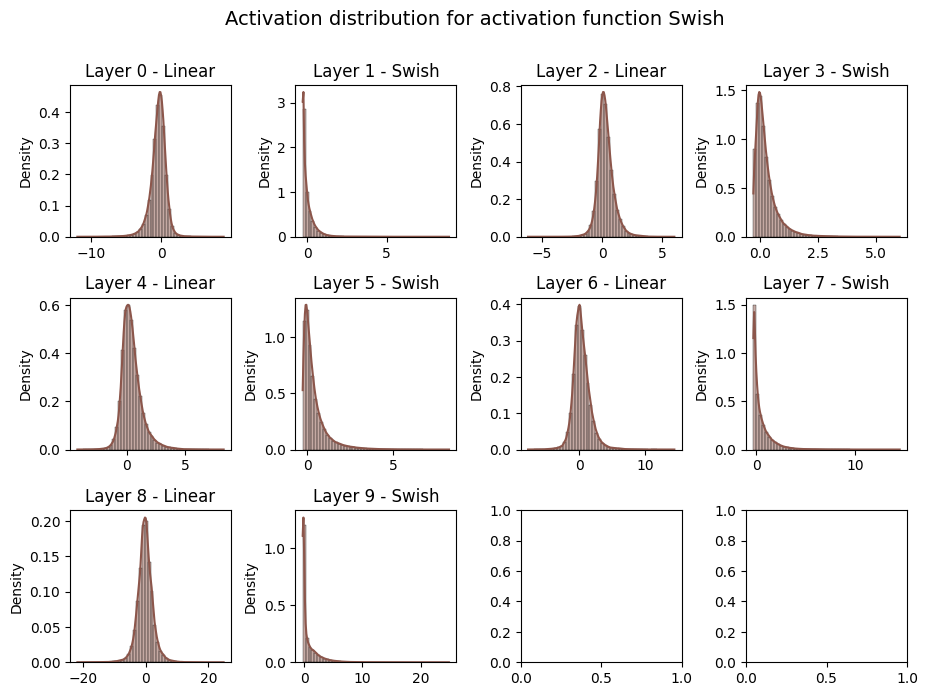

In [ ]:
for i, act_fn_name in enumerate(act_fn_by_name):
    ic(i)
    ic(act_fn_name)
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

In [38]:
from tqdm import tqdm
def measure_number_dead_neurons(net):

    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork
    # ic(neurons_dead)

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_dataloader, leave=False): # Run through whole training set
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

In [39]:
set_seed(42)
# net_relu = BaseNetwork(act_fn=ReLU()).to(device)
act_fn_name = 'relu'
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
measure_number_dead_neurons(net_relu)

{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
relu <class '__main__.Relu'> {'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}
{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 256, 128]}


Number of dead neurons: [0, 0, 0, 4, 3]
In percentage: 0.00%, 0.00%, 0.00%, 1.56%, 2.34%


In [40]:
def vis_dead(net):
    for layer in net.layers[:-1]:
        if isinstance(layer, nn.Linear):
            ic(layer.weight.shape)
            neurons_dead = torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool)

In [41]:
vis_dead(net_relu)

ic| layer.weight.shape: torch.Size([512, 784])
ic| layer.weight.shape: torch.Size([256, 512])
ic| layer.weight.shape: torch.Size([256, 256])
ic| layer.weight.shape: torch.Size([256, 256])
ic| layer.weight.shape: torch.Size([128, 256])
